In [299]:
import math
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import random
from functools import reduce

In [194]:
X_MIN = 0
X_MAX = 2 * math.pi

In [43]:
def normal_error(n: int = 12) -> float:
    s = sum([random.random() for i in range(n)])
    eta = (s - n / 2) / (n / 12) ** 0.5
    return eta

def uniform_error() -> float:
    return -1 + 2 * random.random()

In [23]:
def y_cos(x: float) -> float:
    return math.cos(x)

def y_pol(x: float) -> float:
    return 5 * x ** 3 + x ** 2 + 5

def y_sin(x: float) -> float:
    return x * math.sin(x)

In [195]:
def get_samples(count: int, func: callable, error: callable):
    xs, ys = list(), list()
    for i in range(count):
        x = X_MIN + X_MAX * random.random()
        xs.append(x)
        ys.append(func(x) + error())
    return np.array(xs), np.array(ys)

In [180]:
def mae(trues, preds):
    if len(trues) != len(preds):
        raise Exception(f"Dim of X and y not equal: {len(trues)} and {len(preds)}")
    err = 0
    for t, p in zip(trues, preds):
        err += abs(t - p)
    return err / len(trues)

def mse(trues, preds):
    if len(trues) != len(preds):
        raise Exception(f"Dim of X and y not equal: {len(trues)} and {len(preds)}")
    err = 0
    for t, p in zip(trues, preds):
        err += (t - p) ** 2
    return err / len(trues)

In [317]:
class PolyRegression:
    
    def __init__(self, degree: int):
        self.deg = degree
        self.weights = None

    def fit(self, X: npt.NDArray[np.float64], y: npt.NDArray[np.float64], l2_lambda: float = None):
        if X.shape != y.shape:
            raise Exception(f"Dim of X and y not equal: {X.shape} and {y.shape}")
        V = np.vander(X, N=self.deg+1, increasing=True)
        Vt = V.transpose()
        A = Vt @ V
        if l2_lambda:
            A += np.diag(np.array([l2_lambda] * (self.deg + 1)))
        b = Vt @ y
        w = np.linalg.solve(A, b)
        self.weights = w[::-1]

    def predict(self, X: npt.NDArray[np.float64]) -> list[float]:
        if self.weights is None:
            raise Exception("Not fitted error")
        return [np.polyval(self.weights, x) for x in X]

    def show(self, X: npt.NDArray[np.float64], y: npt.NDArray[np.float64], grid_size: int = 100):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.grid()
        ax.plot(X, y, "ro")
        dx = (X_MAX - X_MIN) / grid_size
        xx = [X_MIN + i*dx for i in range(grid_size + 1)]
        yy = self.predict(xx)
        ax.plot(xx, yy)
        plt.show()

    def get_poly(self):
        p = [f"{w} * x ** {self.deg - i}" for i, w in enumerate(self.weights)] 
        return ' + '.join(p)

In [304]:
def experiment(func: callable, error: callable, degree_variants: list[int]):
    X_train, y_train = get_samples(100, func, error)
    X_test, y_test = get_samples(20, func, error)
    best = {'M': None, 'metric': 100}
    for m in degree_variants:
        p = PolyRegression(m)
        p.fit(X_train, y_train)
        metric = mse(y_test, p.predict(X_test))
        if metric < best['metric']:
            best['metric'] = metric
            best['M'] = m
    
    print(f"Best metric = {best['metric']} with M = {best['M']}")
    p.show(X_test, y_test)
    return best


def experiment_with_lambda(X_train: npt.NDArray[np.float64], y_train: npt.NDArray[np.float64], 
                           X_test: npt.NDArray[np.float64], y_test: npt.NDArray[np.float64],
                           degree_variants: list[int], lambda_variants: list[float]):
    best = {'M': None, 'lambda': None, 'metric': 100, 'model': None}
    for m in degree_variants:
        for lamb in lambda_variants:
            p = PolyRegression(m)
            p.fit(X_train, y_train, l2_lambda=lamb)
            metric = mse(y_test, p.predict(X_test))
            if metric < best['metric']:
                best['metric'] = metric
                best['M'] = m
                best['lambda'] = lamb
                best['model'] = p
    return best

Function: y_cos, error: normal_error
Best metric = 1.4350813001786158 with M = 3


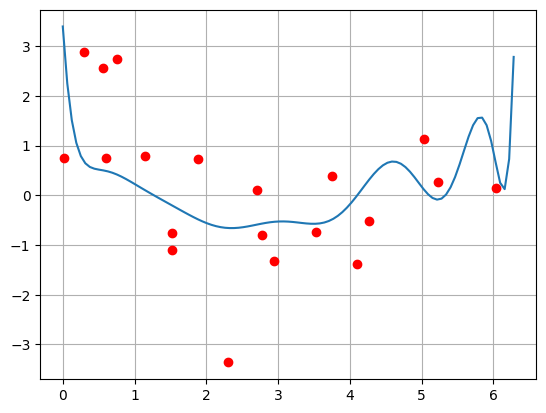

Function: y_cos, error: uniform_error
Best metric = 0.3397822072298168 with M = 4


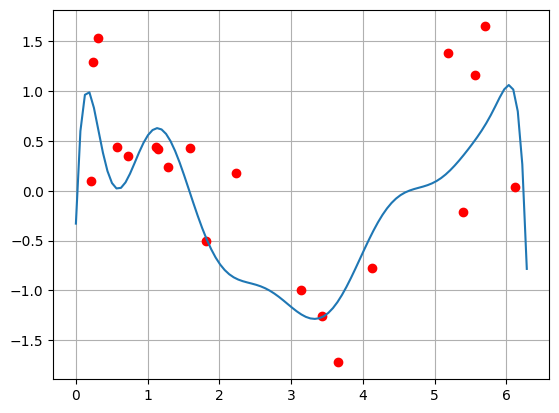

Function: y_pol, error: normal_error
Best metric = 0.8256926565552739 with M = 3


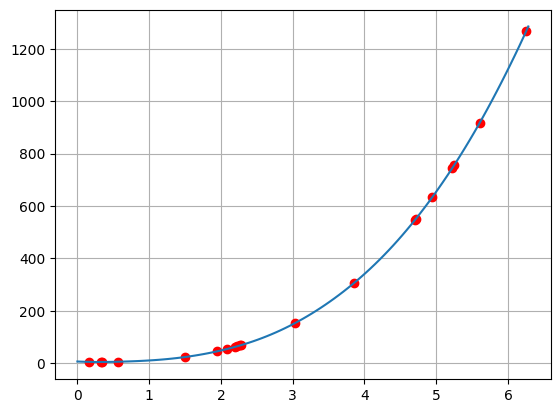

Function: y_pol, error: uniform_error
Best metric = 0.30300931147378296 with M = 12


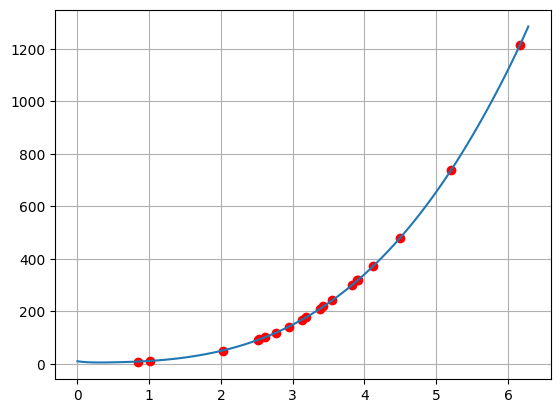

Function: y_sin, error: normal_error
Best metric = 1.2846804188227825 with M = 3


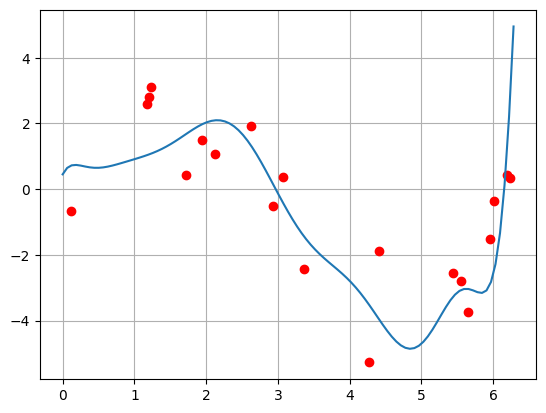

Function: y_sin, error: uniform_error
Best metric = 0.41674754968182615 with M = 6


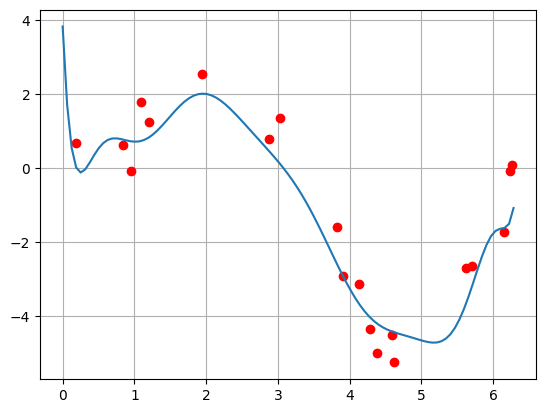

In [225]:
functions = [y_cos, y_pol, y_sin]
errors = [normal_error, uniform_error]
m_vars = range(16)

for func in functions:
    for err in errors:
        print(f"Function: {func.__name__}, error: {err.__name__}")
        experiment(func, err, m_vars)

Best metric = 0.2609316641085167 with M = 5 and lambda = 0.12


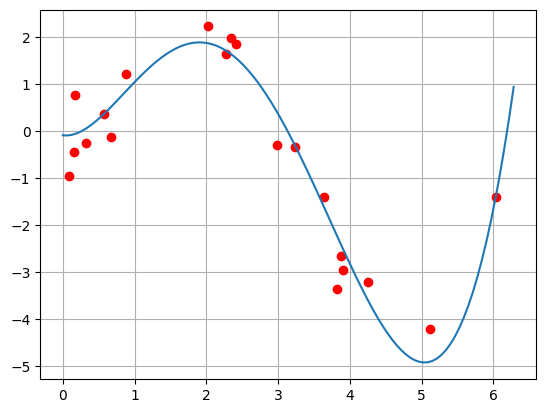

'-0.005056524596134346 * x ** 5 + 0.16366249785586054 * x ** 4 + -1.1973148280783066 * x ** 3 + 2.374893584720402 * x ** 2 + -0.20560104457223932 * x ** 1 + -0.08621599175427498 * x ** 0'

In [318]:
func = y_sin 
error = uniform_error

X_train, y_train = get_samples(100, func, error)
X_test, y_test = get_samples(20, func, error)

lambda_vars = np.concatenate((np.arange(0, 0.4, 0.005), np.arange(0.5, 3, 0.5)))

best = experiment_with_lambda(X_train, y_train, X_test, y_test, m_vars, lambda_vars)
print(f"Best metric = {best['metric']} with M = {best['M']} and lambda = {best['lambda']}")
best['model'].show(X_test, y_test)
best['model'].get_poly()

In [311]:
def cross_validation(X: npt.NDArray[np.float64], y: npt.NDArray[np.float64], count_folds: int,
                    degree_variants: list[int], lambda_variants: list[float]):
    samples = list(zip(X, y))
    fold_size = len(samples) // count_folds
    folders = [samples[i:i+fold_size] for i in range(0, len(samples), fold_size)]
    best_params = {'metric': 100}
    for folder in folders:
        train_folds = list(reduce(lambda l1, l2: l1+l2 if l2 != folder else l1, folders, list()))
        X_train, y_train = map(np.array, zip(*train_folds))
        X_test, y_test = map(np.array, zip(*folder))
        best_fold = experiment_with_lambda(X_train, y_train, X_test, y_test, degree_variants, lambda_variants)
        if best_fold['metric'] < best_params['metric']:
            best_params = best_fold
    return best_params

Best metric = 0.24224544646740087 with M = 5 and lambda = 2.5
MSE on testing samples = 0.3212590542216899


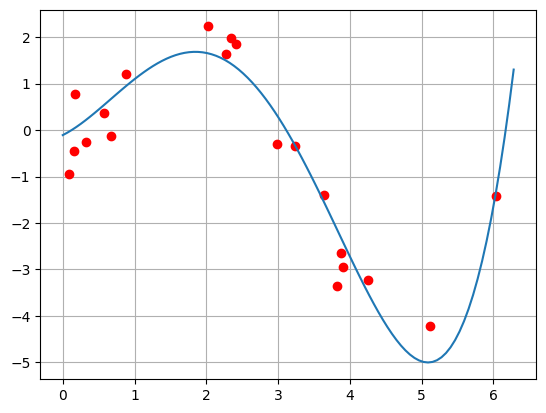

'0.003609663237875625 * x ** 5 + 0.03129007900199153 * x ** 4 + -0.494925819010086 * x ** 3 + 0.8918674317271031 * x ** 2 + 0.7722868166173203 * x ** 1 + -0.10779251478620068 * x ** 0'

In [319]:
best = cross_validation(X_train, y_train, 5, m_vars, lambda_vars)
print(f"Best metric = {best['metric']} with M = {best['M']} and lambda = {best['lambda']}")
print(f"MSE on testing samples = {mse(y_test, best['model'].predict(X_test))}")
best['model'].show(X_test, y_test)
best['model'].get_poly()